<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/TP2/7506R_TP2_GRUPO2_Ensamble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2: Críticas cinematográficas</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


# Importación de librerias

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Modelos
import joblib
from sklearn.ensemble import VotingClassifier

import warnings
warnings.filterwarnings("ignore")

RAND_SEED = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Lectura de archivo


### Desde google drive

In [ ]:
drive.mount('/content/drive')
root_path = "/content/drive/MyDrive/7506R-1C2024-GRUPO02/TP2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Desde maquina local

In [ ]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# root_path = "./"

In [ ]:
train_path = root_path + 'Dataset/train.csv'
test_path = root_path + 'Dataset/test.csv'
sample_path = root_path + 'Dataset/sample_solution.csv'

ds_train = pd.read_csv(train_path)
ds_test = pd.read_csv(test_path)
sample = pd.read_csv(sample_path)

nb_path = root_path + 'Models/naive_bayes.pkl'
rf_path = root_path + 'Models/random_forest.pkl'
xgb_path = root_path + 'Models/xgboost.pkl'

nb = joblib.load(nb_path)
rf = joblib.load(rf_path)
xgb = joblib.load(xgb_path)

# Ensamble

### Utils

In [ ]:
def map_sentiment(ds, invert=False):
  return ds.map({'negativo': 0, 'positivo': 1}) if not invert else ds.map({0: 'negativo', 1: 'positivo'})

In [ ]:
def build_results(pred):
  res = ds_test.copy()
  res.drop(columns=["review_es"], inplace=True)
  res['sentimiento'] = pred
  return res

In [ ]:
def print_positive_negatives(sentimientos):
  total_positives = (sentimientos == "positivo").sum()
  total_negatives = (sentimientos == "negativo").sum()
  print(f"Positives: {total_positives}\nNegatives: {total_negatives}")

In [ ]:
def plot_confussion_matrix(true, pred):
  #Creo matriz de confusión
  tabla = confusion_matrix(true, pred)

  #Grafico matriz de confusión
  sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicciones')
  plt.ylabel('Verdaderos')

  #Reporte
  print(classification_report(true, pred))

In [ ]:
x_test_text = ds_test["review_es"]
x_train_text = ds_train["review_es"]
y_train = map_sentiment(ds_train['sentimiento'])

## Vectorizacion

In [ ]:
def clean_text(text):
  return text.strip()

def tokenizer(text):
  return [w for w in word_tokenize(text) if w.isalpha()]

stoplist = stopwords.words("spanish")

In [ ]:
tfidf_vect = TfidfVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=5,
    stop_words=stoplist,
    ngram_range=(1, 2)
)
x_train = tfidf_vect.fit_transform(x_train_text)
x_test = tfidf_vect.transform(x_test_text)
x_train

<50000x189296 sparse matrix of type '<class 'numpy.float64'>'
	with 7169809 stored elements in Compressed Sparse Row format>

## Ensamblaje y votacion

In [ ]:
ensemble_model = VotingClassifier(
    estimators=[
        ('mnb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='hard'
)

ensemble_model.fit(x_train, y_train)

VotingClassifier(estimators=[('mnb', MultinomialNB(alpha=1)),
                             ('rf',
                              RandomForestClassifier(max_depth=6,
                                                     min_samples_split=6,
                                                     n_estimators=350,
                                                     n_jobs=-1, oob_score=True,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=Non...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=0, ...))])

In [ ]:
# Predicciones
y_pred = ensemble_model.predict(x_test)
y_pred = map_sentiment(pd.Series(y_pred), invert=True)

In [ ]:
resultados_ensamble = build_results(y_pred)
print_positive_negatives(resultados_ensamble['sentimiento'])

Positives: 5246
Negatives: 3353


In [ ]:
# Predicciones
y_pred = ensemble_model.predict(x_train)

              precision    recall  f1-score   support

    negativo       0.94      0.89      0.92     25000
    positivo       0.90      0.95      0.92     25000

    accuracy                           0.92     50000
   macro avg       0.92      0.92      0.92     50000
weighted avg       0.92      0.92      0.92     50000



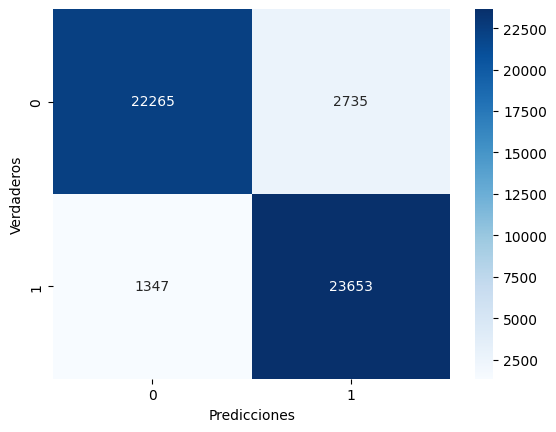

In [ ]:
y_pred = map_sentiment(pd.Series(y_pred), invert=True)
y_train_str = map_sentiment(pd.Series(y_train), invert=True)
plot_confussion_matrix(y_train_str, y_pred) # grafico

## Soft

In [ ]:
ensemble_model_soft = VotingClassifier(
    estimators=[
        ('mnb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'
)

ensemble_model_soft.fit(x_train, y_train)

VotingClassifier(estimators=[('mnb', MultinomialNB(alpha=1)),
                             ('rf',
                              RandomForestClassifier(max_depth=6,
                                                     min_samples_split=6,
                                                     n_estimators=350,
                                                     n_jobs=-1, oob_score=True,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=Non...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=0, ...))],
                 voting='soft')

In [ ]:
# Predicciones
y_pred = ensemble_model_soft.predict(x_test)
y_pred = map_sentiment(pd.Series(y_pred), invert=True)

In [ ]:
resultados_ensemble_soft = build_results(y_pred)
print_positive_negatives(resultados_ensemble_soft['sentimiento'])

Positives: 4952
Negatives: 3647


In [ ]:
# Predicciones
y_pred = ensemble_model_soft.predict(x_train)

              precision    recall  f1-score   support

    negativo       0.96      0.94      0.95     25000
    positivo       0.94      0.96      0.95     25000

    accuracy                           0.95     50000
   macro avg       0.95      0.95      0.95     50000
weighted avg       0.95      0.95      0.95     50000



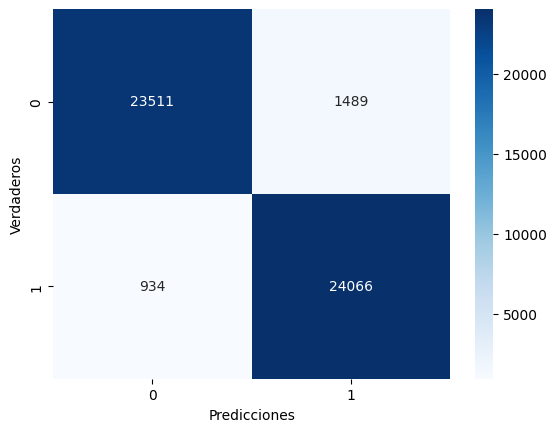

In [ ]:
y_pred = map_sentiment(pd.Series(y_pred), invert=True)
y_train_str = map_sentiment(pd.Series(y_train), invert=True)
plot_confussion_matrix(y_train_str, y_pred) # grafico

## stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base estimators
estimators = [
    ('mnb', nb),
    ('rf', rf),
    ('xgb', xgb),
]

# Initialize StackingClassifier
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    stack_method='predict',  # Use predict method of base estimators
    cv=5  # 5-fold cross-validation during stacking
)

# Train the StackingClassifier
stack_clf.fit(x_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('mnb', MultinomialNB(alpha=1)),
                               ('rf',
                                RandomForestClassifier(max_depth=6,
                                                       min_samples_split=6,
                                                       n_estimators=350,
                                                       n_jobs=-1,
                                                       oob_score=True,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rou...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=0, ...))],
                   final_estimator=LogisticRegression(),
                   stack_method='predict')

In [ ]:
y_pred = stack_clf.predict(x_test)
y_pred = map_sentiment(pd.Series(y_pred), invert=True)

In [ ]:
resultados_stacking = build_results(y_pred)
print_positive_negatives(resultados_stacking['sentimiento'])

Positives: 4475
Negatives: 4124


In [ ]:
# Predicciones
y_pred = stack_clf.predict(x_train)

              precision    recall  f1-score   support

    negativo       0.92      0.93      0.93     25000
    positivo       0.93      0.92      0.93     25000

    accuracy                           0.93     50000
   macro avg       0.93      0.93      0.93     50000
weighted avg       0.93      0.93      0.93     50000



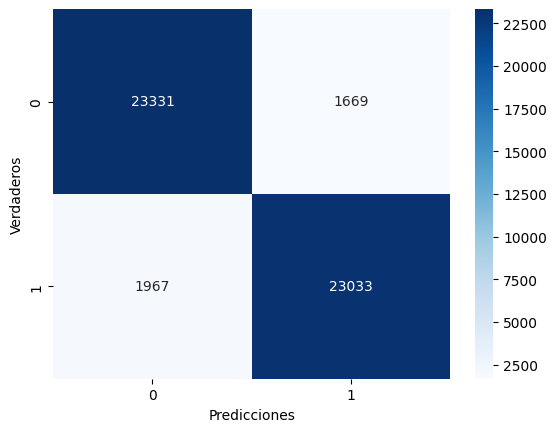

In [ ]:
y_pred = map_sentiment(pd.Series(y_pred), invert=True)
y_train_str = map_sentiment(pd.Series(y_train), invert=True)
plot_confussion_matrix(y_train_str, y_pred) # grafico

# Guardado

In [ ]:
# ensemble
resultados_ensamble.to_csv(root_path + "Dataset/resultados_ensamble.csv", index=False)
joblib.dump(ensemble_model, root_path + 'Models/ensemble_hard.pkl')

# full ensemble soft
resultados_ensemble_soft.to_csv(root_path + "Dataset/resultados_ensemble_soft.csv", index=False)
joblib.dump(ensemble_model_soft, root_path + 'Models/ensemble_soft.pkl')

# stacking
resultados_stacking.to_csv(root_path + "Dataset/resultados_stacking.csv", index=False)
joblib.dump(stack_clf, root_path + 'Models/stacking.pkl')

['/content/drive/MyDrive/7506R-1C2024-GRUPO02/TP2/Models/stacking.pkl']